In [7]:
import albumentations
import json
import numpy as np
import os
import tokenizers
import torch
import wandb

from glob import glob
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    Trainer,
    TrainingArguments
)
from typing import Dict, List, Tuple

import params

In [8]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [53]:
with open('data/train_data.json', 'r') as f:
    train_data = json.load(f)
with open('data/val_data.json', 'r') as f:
    val_data = json.load(f)
id2label = {cat["id"]: cat["name"] for cat in val_data["categories"]}
label2id = {name: cat_id for cat_id, name in id2label.items()}

In [54]:
def process_data(data: dict, data_path: str):
    """Convert data format

    Convert data format from json with multiple keys to a list of [image_info, image annotations]
    :param data: input data
    :type data: json
    :param data_path: path to images
    :type data_path: str
    :return: converted data into a list
    :rtype: [dict, [dict]]
    """

    processed_data = []
    for image_data in tqdm(data["images"]):
        image_path = os.path.join(data_path, image_data["file_name"])
        if not os.path.isfile(image_path):
            continue
        
        height = image_data["height"]
        width = image_data["width"]
        curr_image_id = image_data["id"]
        curr_annos = []
        for anno in data["annotations"]:
            if anno["image_id"] != curr_image_id:
                continue
            
            x, y, w, h = anno["bbox"]
            if w == 0 or h == 0:
                continue
            if x < 0:
                x = 0
            if y < 0:
                y = 0
    
            if x >= width:
                continue
            if x + w > width:
                w = width - x
            
            if y >= height:
                continue
            if y + h > height:
                h = height - y
            
            anno["bbox"] = [x, y, w, h]
            curr_annos.append(anno)

        if len(curr_annos) == 0:
            continue
    
        curr_image_data = image_data.copy()
        curr_image_data["image_path"] = image_path
        processed_data.append((curr_image_data, curr_annos))

    return processed_data

In [55]:
val_data = process_data(val_data, "./data/images/")
train_data = process_data(train_data, "./data/images/")

100%|█████████████████████████████████████| 4760/4760 [00:02<00:00, 1860.10it/s]


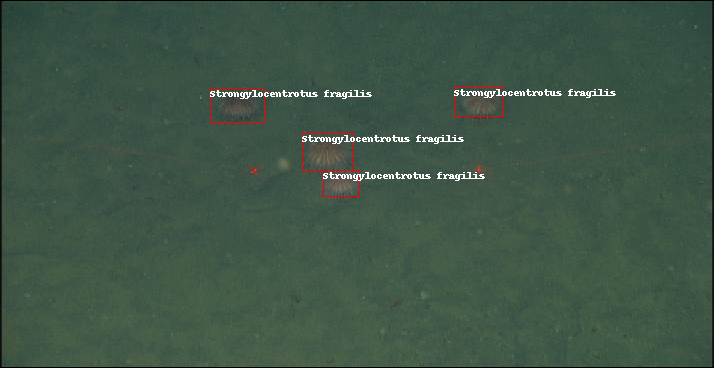

In [12]:
image = Image.open(val_data[50][0]["image_path"])
annotations = val_data[50][1]
draw = ImageDraw.Draw(image)

for anno in annotations:
    box = anno["bbox"]
    class_idx = anno["category_id"]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")
image

In [13]:
class SeaWorldDataset(Dataset):
    """
    """

    def __init__(self, data: List[Tuple[Dict, List[Dict]]], image_processor, is_augment: str = True):
        self._data = data
        self._image_processor = image_processor

        if is_augment:
            self._transform = albumentations.Compose(
                [
                    albumentations.Resize(580, 580),
                    albumentations.HorizontalFlip(p=.5),
                    albumentations.RandomBrightnessContrast(p=.5),
                    albumentations.Rotate(limit=30),
                    albumentations.RandomCrop(480, 480)
                ],
                bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
            )
        else:
            self._transform = albumentations.Compose(
                [
                    albumentations.Resize(480, 480),
                ],
                bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
            )

    def __len__(self):
        return len(self._data)

    @staticmethod
    def _format_processed_annotations(bboxes, categories, image_id):
        """
        """

        processed_annotations = []
        for bbox, category_id in zip(bboxes, categories):
            processed_annotations.append(
                {
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [int(arg + 0.5) for arg in bbox],
                    "isCrowd": 0,
                    "area": int(bbox[2] * bbox[3] + 0.5)
                }
            )

        return processed_annotations

    def __getitem__(self, index) -> Tuple[np.ndarray, List[Dict], int]:
        """
        """

        image_data, annotations = self._data[index]
        image_id = image_data["id"]
        bboxes, categories = [], []
        for annotation in annotations:
            bbox = annotation["bbox"]
            category_id = annotation["category_id"]
            bboxes.append(bbox)
            categories.append(category_id)

        image = np.array(Image.open(image_data["image_path"]).convert("RGB"))
        out = self._transform(
            image=image,
            bboxes=bboxes,
            categories=categories
        )
        annotations = self._format_processed_annotations(
            out["bboxes"], out["categories"], image_id
        )

        processed_image = self._image_processor.preprocess(
            images=image, annotations={"image_id": image_id, "annotations": annotations}, return_tensors="pt"
        )
        for key, val in processed_image.items():
            processed_image[key] = val[0]

        return processed_image

In [62]:
checkpoint = "facebook/detr-resnet-50"
checkpoint_yolos = "hustvl/yolos-small"
checkpoint_cond_detr = "microsoft/conditional-detr-resnet-50"
checkpoint_deta = "jozhang97/deta-swin-large"
#image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor = AutoImageProcessor.from_pretrained(checkpoint_yolos)
is_yolo = False
run_name = "yolos_last_layer_tune"

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [63]:
train_dataset = SeaWorldDataset(train_data, image_processor, is_augment=True)
val_dataset = SeaWorldDataset(val_data, image_processor, is_augment=False)

In [64]:
error_samples = []
for idx, sample in tqdm(enumerate(train_dataset)):
    if sample["labels"]["boxes"].isnan().any():
        error_samples.append((idx, sample))
for idx, sample in tqdm(enumerate(val_dataset)):
    if sample["labels"]["boxes"].isnan().any():
        error_samples.append((idx, sample))

4759it [04:58, 15.93it/s]
1190it [01:14, 16.01it/s]


In [26]:
def collate_fn(batch, is_yolo=False):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    if not is_yolo:
        batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [30]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint_deta,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json: 100%|█████████████████████████| 7.02k/7.02k [00:00<00:00, 4.65MB/s]
model.safetensors: 100%|█████████████████████| 879M/879M [01:31<00:00, 9.57MB/s]
Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-swin-large and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([133, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([133, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the mod

In [32]:
model.model

DetaModel(
  (backbone): DetaBackboneWithPositionalEncodings(
    (model): SwinBackbone(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinLayer(
                (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=192, out_features=192, bias=True)
                    (key): Linear(in_features=192, out_features=192, bias=True)
                    (value): Linear(in_features=192, out_features=192, bias=True)
                    (dropout): Dropo

In [20]:
training_args = TrainingArguments(
    output_dir="yolos_finetuned",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=5,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    use_cpu=True,
    report_to="wandb",
    run_name=run_name
)


In [14]:
for param in model.vit.parameters():
    param.requires_grad = False

In [ ]:
os.environ["WANDB_PROJECT"] = params.WANDB_PROJECT # name your W&B project
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=lambda batch: collate_fn(batch, is_yolo),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
)

In [16]:
trainer.train()

wandb: Currently logged in as: matt-zak. Use `wandb login --relogin` to force relogin


Step,Training Loss
5,8.967500
10,9.526700
15,9.159200
20,9.366200
25,9.253400
30,8.771800
35,8.560800
40,8.788100
45,8.393600
50,8.448600


KeyboardInterrupt: 

In [ ]:
wandb.finish()